In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Carregando o dataset de Churn real do Kaggle
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# --- Pré-processamento e Limpeza dos Dados ---
# 1. Substituir valores ' ' na coluna TotalCharges por NaN e converter para numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Lidar com valores nulos (NaN)
df.dropna(inplace=True)

# 3. Mapear a classe 'Churn' para 0 e 1
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# 4. Separar colunas categóricas e numéricas
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col != 'Churn']

# 5. Aplicar One-Hot Encoding nas colunas categóricas
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 6. Remover a coluna customerID, que não é útil para o modelo
# df.drop(columns=['customerID'], inplace=True)

# Exibindo as colunas após o One-Hot Encoding
print("Colunas do DataFrame após o One-Hot Encoding:")
print(df.columns)

# Separar as características (X) e a classe (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

# Separar dados em treino e teste
# O 'stratify=y' garante que a proporção de churn seja a mesma em treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nDados prontos para o treinamento!")

Colunas do DataFrame após o One-Hot Encoding:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'customerID_0003-MKNFE', 'customerID_0004-TLHLJ',
       'customerID_0011-IGKFF', 'customerID_0013-EXCHZ',
       'customerID_0013-MHZWF',
       ...
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object', length=7062)

Dados prontos para o treinamento!


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:18:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Relatório de Classificação com XGBoost e SMOTE em dados reais:
              precision    recall  f1-score   support

   Não-Churn       0.85      0.84      0.85      1549
       Churn       0.58      0.59      0.58       561

    accuracy                           0.78      2110
   macro avg       0.71      0.72      0.71      2110
weighted avg       0.78      0.78      0.78      2110



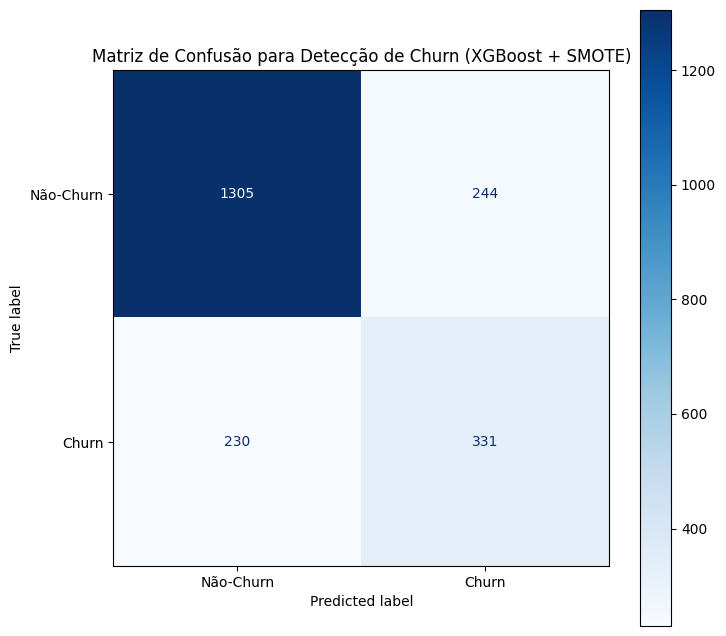

In [16]:
# Aplicação do SMOTE para balancear a classe minoritária
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escolher e treinar o modelo XGBoost com os dados balanceados
modelo_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
modelo_xgb.fit(X_train_resampled, y_train_resampled)

# Avaliação do modelo com os dados de TESTE originais (não balanceados)
y_pred_xgb = modelo_xgb.predict(X_test)
print("\nRelatório de Classificação com XGBoost e SMOTE em dados reais:")
print(classification_report(y_test, y_pred_xgb, target_names=['Não-Churn', 'Churn']))

# Gerar e exibir a matriz de confusão
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Não-Churn', 'Churn'])

fig, ax = plt.subplots(figsize=(8, 8))
disp_xgb.plot(cmap=plt.cm.Blues, values_format='.0f', ax=ax)
plt.title('Matriz de Confusão para Detecção de Churn (XGBoost + SMOTE)')
plt.show()

In [6]:
# Salvar o modelo treinado para uso futuro
import joblib

joblib.dump(modelo_xgb, 'modelo_churn_xgboost_real.pkl')
print("\nModelo de churn (XGBoost) salvo como modelo_churn_xgboost_real.pkl")


Modelo de churn salvo como modelo_churn.pkl
